In [10]:
import numpy as np
import pandas as pd
import re
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import time
import os

import neuro_morpho_toolbox as nmt
from neuro_morpho_toolbox.flat_map import *

import sklearn
from sklearn.decomposition import PCA
import umap
from sklearn import metrics
from skimage import io, transform, exposure

import pickle
%matplotlib inline


In [2]:
custom_layer_dict = layer_dict
custom_layer_dict[0] = 'Non-cortical'
custom_layer_list = layer_list + ['Non-cortical']


In [3]:

[ss] = pickle.load(open('slice_set_100_test.pickle', 'rb'))

##########################################################################################
# Additional features of ss
##########################################################################################

# 1. normal vector
anchor_df = None
for cur_x_slice in ss.x_list_valid:
    if anchor_df is None:
        anchor_df = ss.dict[cur_x_slice].anchor[['vx', 'vy']]
    else:
        anchor_df = pd.concat([anchor_df, ss.dict[cur_x_slice].anchor[['vx', 'vy']]], axis=0)
# anchor_df.rename(columns={'x':'x_um', 'y':'y_um'}, inplace=True)
anchor_df = pd.concat([ss.m2d.loc[anchor_df.index], anchor_df], axis=1)

print(anchor_df.shape)
anchor_df.head()

# 2. anchor area
def get_anchor_area(ss, cur_x_slice):
    if ss.dict[cur_x_slice].anchor is None:
        return None
    canchor = ss.dict[cur_x_slice].anchor.copy()
    area = []
    for i in canchor.index.tolist():
        carea = 0
        cz = canchor.loc[i, 'x_expand']
        # Find left neighbor
        tp = canchor[canchor['x_expand']<cz].copy()
        if len(tp)>0:
            carea += np.abs(tp['x_expand'].max()-cz)/2
        # Find right neighbor
        tp = canchor[canchor['x_expand']>cz].copy()
        if len(tp)>0:
            carea += np.abs(tp['x_expand'].min()-cz)/2
        carea *= nmt.annotation.space['z']
        carea *= ss.x_thickness
        carea *= 1e-6 # unit mm*2
        area.append(carea)
    return pd.DataFrame({'area':area}, index=canchor.index)
    
area_df = None
for cur_x_slice in ss.x_list_valid:
    canchor_area = get_anchor_area(ss, cur_x_slice)
    if area_df is None:
        area_df = canchor_area
    else:
        area_df = pd.concat([area_df, canchor_area], axis=0)

anchor_df = pd.concat([anchor_df, area_df], axis=1)

anchor_df.head()

(4404, 10)


,x,z_expand,x_ccf,y_ccf,z_ccf,is_anchor,region,is_boundary,vx,vy,area
74_120_215,74.0,-96.700143,74,120,215,True,FRP,True,-0.999983,0.005857,0.014106
74_115_205,74.0,-85.415447,74,115,205,True,FRP,True,0.699000,0.715122,0.036334
74_110_188,74.0,-67.632699,74,110,188,True,FRP,True,-0.632414,0.774630,0.042984
74_105_173,74.0,-51.028485,74,105,173,True,FRP,True,0.360569,0.932733,0.028041
74_102_177,74.0,-45.200058,74,102,177,True,FRP,True,0.360569,0.932733,0.014053


In [197]:
def get_layer_thickness_v2(region='Global', anchor_df=anchor_df):
    if not region=='Global':
        region_id = nmt.bs.name_to_id(region)
    ct = 0
    res = []
    anchor_df_tp = anchor_df.copy()
    anchor_df_tp = anchor_df_tp[((anchor_df_tp.x_ccf>=160) & (anchor_df_tp.x_ccf<=400))]
    if not region == 'Global':
        anchor_df_tp = anchor_df_tp[anchor_df_tp.region==region]

    anchor_sample = np.random.choice(np.arange(0, len(anchor_df_tp), 1, dtype=int), 
                                     min(1000, len(anchor_df_tp)), 
                                     replace=False)
    # for cname in anchor_df_tp.index[anchor_sample].tolist():
    for cname in anchor_df_tp.index.tolist():
        tp = anchor_df_tp.loc[cname]
    #     uv = np.array([tp.vx, tp.vy]/np.sqrt(2)/space)
        cx = int(tp.x_ccf)
        if ((cx < 0) | (cx >= cortex_layer_array.shape[0])):
            continue
        step = 0.1
        cy = np.array(np.linspace(0, 1000, 1001)*tp.vy*step, dtype=int) + tp.y_ccf
        cz = np.array(np.linspace(0, 1000, 1001)*tp.vx*step, dtype=int) + tp.z_ccf

        ind = ((cy>=0) & (cy<cortex_layer_array.shape[1]) & (cz>=0) & (cz<cortex_layer_array.shape[2]))
        cy = cy[ind]
        cz = cz[ind]

        tp = pd.DataFrame({'x':[cx]*len(cy),
                          'y':cy,
                          'z':cz
                         })
    #     # Remove duplicates
    #     tp = tp.drop_duplicates()
        if not region=='Global':
            tp['region'] = cortex_region_array[tp.x.tolist(), 
                                      tp.y.tolist(), 
                                      tp.z.tolist()]
            tp = tp[tp['region']==region_id]

        cres = cortex_layer_array[tp.x.tolist(), 
                                  tp.y.tolist(), 
                                  tp.z.tolist()]
        cres = cres[cres>0]
        valid = True
        for i in [1,2,4,5,6]:
            if not i in cres:
                valid = False
        if valid:  # Only consider layers that are thick enough
            res = res + list(cres)
            ct += 1
            tp = pd.Series(cres).value_counts()
    res = pd.Series(res).value_counts()
    res = res / ct * step * space
    res = res.rename(index=layer_dict).sort_index()
    return res

layer_thickness_dict={}
layer_thickness_dict['Global'] = get_layer_thickness_v2('Global')
layer_thickness_dict['MOp'] = get_layer_thickness_v2('MOp')
layer_thickness_dict['MOs'] = get_layer_thickness_v2('MOs')
layer_thickness_dict['SSp'] = get_layer_thickness_v2('SSp')
layer_thickness_dict['SSs'] = get_layer_thickness_v2('SSs')


In [198]:
for i in list(layer_thickness_dict.keys()):
    print(i, layer_thickness_dict[i].sum())

Global 1199.0235156771182
MOp 1484.0104166666665
MOs 1404.6875
SSp 1358.9451827242526
SSs 1233.346153846154


In [89]:
# '''
# Get the average layer thickness for regions.
# '''

# layer_thickness_dict={}
# def get_layer_thickness(region='Global', anchor_df=anchor_df):
#     # Average cortical thickness
#     ct = 0
#     res = []
#     anchor_df = anchor_df[((anchor_df.x_ccf>=160) & (anchor_df.x_ccf<=400))]
#     if not region == 'Global':
#         anchor_df = anchor_df[anchor_df.region==region]
#     if len(anchor_df)<10:
#         return None
#     anchor_sample = np.random.choice(np.arange(0, len(anchor_df), 1, dtype=int), 
#                                      min(1000, len(anchor_df)), 
#                                      replace=False)
#     for cname in anchor_df.index[anchor_sample].tolist():
#         tp = anchor_df.loc[cname]
#         uv = np.array([tp.vx, tp.vy]/np.sqrt(2)/space)
#         cx = int(tp.x_ccf)
#         if ((cx < 0) | (cx >= cortex_layer_array.shape[0])):
#             continue
#         cy = np.array(np.linspace(0, 5000, 5001)*tp.vy/space, dtype=int) + tp.y_ccf
#         cz = np.array(np.linspace(0, 5000, 5001)*tp.vx/space, dtype=int) + tp.z_ccf

#         ind = ((cy>=0) & (cy<cortex_layer_array.shape[1]) & (cz>=0) & (cz<cortex_layer_array.shape[2]))
#         cy = cy[ind]
#         cz = cz[ind]

#         cres = cortex_layer_array[cx, cy, cz]
#         cres = cres[cres>0]
#         if len(cres) > 500:  # Only consider layers that are thick enough
#             res = res + list(cres)
#             ct += 1
#     res = pd.Series(res).value_counts()
#     res = res / ct

#     res = res.rename(index=layer_dict).sort_index()
#     return res

# layer_thickness_dict['Global'] = get_layer_thickness('Global')
# layer_thickness_dict['MO'] = get_layer_thickness('MO')
# layer_thickness_dict['MOp'] = get_layer_thickness('MOp')
# layer_thickness_dict['MOs'] = get_layer_thickness('MOs')
# layer_thickness_dict['SSp'] = get_layer_thickness('SSp')
# layer_thickness_dict['SSs'] = get_layer_thickness('SSs')


In [5]:
def my_get_segments(swc):
    # lab = [i for i,name in enumerate(swc.index.tolist()) if swc.loc[name, "parent"]!=(-1)]
    child = swc[(swc.parent.isin(swc.index.tolist()))]
    parent = swc.loc[child.parent]
    rho, theta, phi = nmt.cart2pol_3d(np.array(child[["x", "y", "z"]]) - np.array(parent[["x", "y", "z"]]))
    res = pd.DataFrame({"type": child.type,
                        "rho": rho,
                        "theta": theta,
                        "phi": phi,
                        "x": (np.array(child.x) + np.array(parent.x)) / 2,
                        "y": (np.array(child.y) + np.array(parent.y)) / 2,
                        "z": (np.array(child.z) + np.array(parent.z)) / 2,
#                         "degree":child.degree
                        })
    res.index = range(1, len(child)+1)
    # soma
    soma = swc[((swc.type==1) & (swc.parent==-1))]
    if len(soma)>0:
        soma_res = pd.DataFrame({"type": 1,
                                 "rho": 1,
                                 "theta": 0,
                                 "phi": 0,
                                 "x": soma.x.iloc[0],
                                 "y": soma.y.iloc[0],
                                 "z": soma.z.iloc[0],
#                                 "degree":swc.degree.iloc[0]
                                },
                                index=[0])
        res = soma_res.append(res)
    res.dropna()
    return res

def my_normalize(x):
    return x / np.sqrt(x[0]**2+x[1]**2)

def my_projection(x,y):
    return np.dot(x, y)

def my_weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

## Define arbor class and plotting functions

In [6]:
def get_point_set(df, projection_feild, x_position, x_thickness=1000):
    ps = df.loc[((df.x>(x_position-x_thickness/2)) & (df.x<=(x_position+x_thickness/2))), ['z', 'y', 'rho']]
    if len(ps)==0:
        return None
    ps = ps.rename(columns={'z':'x'})
    ps.x = (ps.x / space).astype('int32')
    ps.y = (ps.y / space).astype('int32')
    ps['voxel'] = [str(int(ps.loc[i, 'x']))+"_"+str(int(ps.loc[i, 'y'])) for i in ps.index.tolist()]
    # Only consider points in the cortex
    ps = ps[ps.voxel.isin(projection_feild.index.tolist())]
    if len(ps)==0:
        return None
    ps['anchor'] = projection_feild.loc[ps.voxel.tolist(), 'anchor'].tolist()
    return ps


In [7]:
class cortical_arbor:
    def __init__(self, df, ss, type_list=[2], celltype=None, name=None):
        valid_header = pd.Series(['type', 'rho', 'theta', 'phi', 'x', 'y', 'z'])
        assert valid_header.isin(df.columns.tolist()).all(), 'df missing necessary columns'
        ##################################################################################
        # 0. Meta data
        ##################################################################################
        self.get_celltype(celltype)
        self.get_name(name)
        self.valid = True
        
        ##################################################################################
        # 1. Segments & center
        ##################################################################################
        self.seg = df
        self.seg = self.get_seg_type(type_list)
        # Flip if the arbor is in the contra-lateral side
        self.seg, self.hemisphere = self.get_hemisphere()
        if len(self.seg)==0:
            self.valid = False
            return
        self.seg = self.get_cortical()
        if len(self.seg)==0:
            self.valid = False
            return
        self.seg['layer'] = self.get_layer()

        # cluster center
        center_name, self.outlier_ratio = self.get_cluster_center(silent=True)  # outlier points will be removed
#         if ((len(self.seg)==0) | (self.outlier_ratio>10)):
#             self.valid = False
#             return
        self.center = self.seg.loc[center_name]
        
#         # n_branches
#         self.n_branches = (self.seg.degree>2).sum()
#         if self.n_branches == 0:
#             self.valid = False
#             return
        
        ##################################################################################
        # 2. Cortical expansion
        ##################################################################################        
        self.get_surface(ss)
        if len(self.surface)==0:
            self.valid = False
            return
        else:
            distance = metrics.euclidean_distances(self.surface[['2d_x', '2d_y']])
            cid = np.argmin(np.mean(distance, axis=1))
        self.surface_center = self.surface.iloc[cid,:]
#         self.surface_area = len(self.surface.anchor.value_counts())  # TODO: consider anchor area        
        self.get_depth(ss)
        
        ##################################################################################
        # 3. Features
        ##################################################################################
        radius, volume = self.get_volume()
        depth_mean, depth_std = my_weighted_avg_and_std(np.array(self.depth.depth).reshape(-1,),
                                                        np.array(self.depth.rho).reshape(-1,))
#         depth_mean = self.depth.depth.mean()
#         depth_std = self.depth.depth.std()
        self.feature = pd.Series({'2d_x':self.surface_center['2d_x'],
                                  '2d_y':self.surface_center['2d_y'],
                                  '2d_area':self.surface_area,
                                  'total_length':np.sum(self.seg.rho),
                                  'radius':radius,
                                  'volume':volume,
                                  'depth_mean':depth_mean,
                                  'depth_std':depth_std
                                 })        
        
        ##################################################################################
        # 4. Plotting data
        ##################################################################################
        self.slice, self.slice_df = self.get_slice(ss, x_thickness=1000)
        self.rot_seg = self.get_rotated_segments(ss)
        if self.rot_seg is None:
            self.valid = False
            return
        cc = pd.DataFrame(self.center).transpose()
        cc = self.rotate_swc(cc, ss)
        self.center = self.center.append(pd.Series({'name':center_name, 
                                                    'rx':cc.x,
                                                    'ry':cc.y
                                                   }))
         
        return
    
    def get_celltype(self, celltype):
        self.celltype = celltype
        return
    
    def get_name(self, name):
        self.name = name
        return
    
    def get_seg_type(self, type_list=[2]):
        tp = self.seg.copy()
        tp = tp[tp.type.isin(type_list)]
        return tp
    
    def get_hemisphere(self):
        tp = self.seg.copy()
        if tp.z.median()>=(nmt.annotation.micron_size['z']/2):
            hemisphere = 'contra'
            tp.z = nmt.annotation.micron_size['z'] - tp.z
        else:
            hemisphere = 'ipsi'
        tp = tp[tp.z < (nmt.annotation.micron_size['z']/2)]
        return tp, hemisphere
    
    def get_cortical(self):
        tp = self.seg.copy()
        tp.loc[:, ['x', 'y', 'z']] = (tp.loc[:, ['x', 'y', 'z']]/space).astype('int')
        tp = tp[((tp.x>=0) & (tp.x<cortex_region_array.shape[0]) &
                 (tp.y>=0) & (tp.y<cortex_region_array.shape[1]) &
                 (tp.z>=0) & (tp.z<cortex_region_array.shape[2])
                )]
        tp['is_cortical'] = list(cortex_region_array[tp.x, tp.y, tp.z]>0)
        tp = tp[tp.is_cortical]                  # Keep cortex only
        return self.seg.loc[tp.index]
    
    def get_layer(self):
        df = self.seg.copy()[['x', 'y', 'z']]
        df = (df/space).astype('int')
        res = [custom_layer_dict[cortex_layer_array[df.x[i], 
                                                    df.y[i], 
                                                    df.z[i]]] for i in df.index.tolist()]
        return res
    
    def assign_x_slice(self, ss):
        df = self.seg.copy()
        if len(df)==0:
            return 0
        
        x_thickness = ss.x_thickness
        x_list = sorted(ss.x_list_valid)

        bins = [int((i-x_thickness/2)) for i in x_list+[x_list[-1]+x_thickness]]
        density = np.histogram(df.x, bins, weights=df.rho)[0]
        res = x_list[np.argmax(density)]
        return res

    def get_slice(self, ss, x_thickness=500, silent=True):
        df = self.seg.copy()
        x_slice = self.assign_x_slice(ss)
        total_length = np.sum(df.rho)
        df = df[((df.x>=(x_slice-x_thickness/2)) & (df.x<(x_slice+x_thickness/2)))]
        slice_length = np.sum(df.rho)
        if not silent:
            print("%.2f%% arbor selected." % (slice_length / total_length * 100))
        return x_slice, df

    def get_cluster_center(self, silent=True):
        df = self.seg.copy()[['x', 'y', 'z']]
        distance = metrics.euclidean_distances(df)
        cid = np.argmin(np.mean(distance, axis=1))
        cid = df.index.tolist()[cid]
        # exclude outliers
        md = metrics.euclidean_distances(np.array(df.loc[cid]).reshape(1, 3), df).reshape(-1,)
#         tp = df[md>(np.median(md)+2*min(500, np.std(md)))] # define outliers
        tp = df[md>1000] # define outliers
        outlier_ratio = len(tp) / len(df) * 100
        if not silent:            
            if outlier_ratio>10:
                print("%s: %.2f%% arbor excluded." % (self.name, outlier_ratio))
        self.seg.drop(index=tp.index, inplace=True)
        # Re-center
        df = self.seg.copy()[['x', 'y', 'z']]
        distance = metrics.euclidean_distances(df)
        cid = np.argmin(np.mean(distance, axis=1))
        cid = df.index.tolist()[cid]
        return cid, outlier_ratio
    
    def get_volume(self, thres=0.7):
        df = self.seg.copy()
        distance = metrics.euclidean_distances(np.array(self.center[['x', 'y', 'z']]).reshape(1,3),
                                               np.array(self.seg[['x', 'y', 'z']]).reshape(-1,3)
                                              )
        df['distance'] = distance.reshape(-1,)
        df = df.sort_values(['distance'], ascending=True)
        tp = df[df.rho.cumsum()<(np.sum(df.rho)*thres)]
        if len(tp) == 0:
            return np.nan, np.nan
        radius = tp.distance.tolist()[-1]
        volume = 4/3 * np.pi * radius**3
        return radius, volume
    
    def rotate_swc(self, df, ss, median_node=None):
#         cur_x_slice = self.slice
   
        if median_node is None:
            median_node = self.center.copy()[['z', 'y']] / space
            median_node.rename(index={'z':'x'}, inplace=True)
            median_node = median_node.astype('int')
        cur_x_slice_ind = np.argmin(np.abs(np.array(ss.x_list_valid - self.center['x'])))
        cur_x_slice = ss.x_list_valid[cur_x_slice_ind]

        df= df.copy()[['z', 'y', 'layer', 'type']]
        df.rename(columns={'z':'x'}, inplace=True)

        # Find rotation vectors
        if not str(median_node.x)+"_"+str(median_node.y) in ss.dict[cur_x_slice].pf.index.tolist():
            return None
        cur_pf = ss.dict[cur_x_slice].pf.loc[str(median_node.x)+"_"+str(median_node.y)]
        cur_anchor = ss.dict[cur_x_slice].anchor.loc[cur_pf.anchor]
        cur_orgin = cur_anchor[['x', 'y']] * space
        v1 = cur_anchor[['vx', 'vy']]
        v2 = v1.copy()
        v2[['vx', 'vy']] = [-v1['vy'], v1['vx']]
        rot_array = np.array([[v2['vx'], v1['vx']],
                              [v2['vy'], v1['vy']]
                             ])

        rot_swc = pd.DataFrame(np.dot(df[['x', 'y']] - cur_orgin, rot_array), index=df.index, columns=['x', 'y'])
        rot_swc = pd.concat([rot_swc, df[['layer', 'type']]], axis=1)
        return rot_swc

    def get_rotated_segments(self, ss):
        df = self.seg.copy()
        cur_x_slice = self.slice
        
        segments = nmt.pol2cart_3d(df.rho, df.theta, df.phi)
        df_parent = df.copy()
        df_parent[['x', 'y', 'z']] = df_parent[['x', 'y', 'z']] - segments/2
        df_child = df.copy()
        df_child[['x', 'y', 'z']] = df_child[['x', 'y', 'z']] + segments/2

        # Fix rotation vector
        median_node = self.center[['z', 'y']] / space
        median_node.rename(index={'z':'x'}, inplace=True)
        median_node = median_node.astype('int')

        rot_child = self.rotate_swc(df_child, ss, median_node)
        rot_parent = self.rotate_swc(df_parent, ss, median_node)
        if ((rot_child is None) | (rot_parent is None)):
            return None
        
        tp = pd.DataFrame(index=range(len(df)*3))
        tp['Xe'] = np.nan
        tp['Ye'] = np.nan
        tp['Le'] = np.nan
        tp['Te'] = np.nan
        
        ind1 = list(np.arange(len(df))*3+0)
        ind2 = list(np.arange(len(df))*3+1)
        ind3 = list(np.arange(len(df))*3+2)
        tp.loc[ind1, 'Xe'] = rot_child.x.tolist()
        tp.loc[ind1, 'Ye'] = rot_child.y.tolist()
        tp.loc[ind1, 'Le'] = rot_child.layer.tolist()
        tp.loc[ind1, 'Te'] = rot_parent['type'].tolist()
        
        tp.loc[ind2, 'Xe'] = rot_parent.x.tolist()
        tp.loc[ind2, 'Ye'] = rot_parent.y.tolist()
        tp.loc[ind2, 'Le'] = rot_parent.layer.tolist()
        tp.loc[ind2, 'Te'] = rot_parent['type'].tolist()
        
        tp.loc[ind3, 'Le'] = rot_parent.layer.tolist()
        tp.loc[ind3, 'Te'] = rot_parent['type'].tolist()
        
        tp.Le = tp.Le.map(layer_dict_reverse)

        tp.Xe = np.array(tp.Xe, dtype=np.float)
        tp.Ye = np.array(tp.Ye, dtype=np.float)
        tp.Le = np.array(tp.Le, dtype=np.int)
        tp.Te = np.array(tp.Te, dtype=np.int)
        return tp
    
    ##########################################################################################
    # Functions for flat map
    ##########################################################################################
    def get_surface(self, ss):
        ps = pd.DataFrame(columns=['x', 'y', 'rho', 'voxel', 'anchor'])
        for cur_x_position in ss.x_list_valid:
            cur_shell = ss.dict[cur_x_position].shell
            cur_anchor = ss.dict[cur_x_position].anchor
            cur_pf = ss.dict[cur_x_position].pf
            if cur_shell is None:
                continue
            cur_ps = get_point_set(self.seg,
                                   projection_feild=cur_pf, 
                                   x_position=cur_x_position,
                                   x_thickness=ss.x_thickness
                                  )
            if cur_ps is None:
                continue                
            ps = pd.concat([ps, cur_ps], axis=0)
        ps = ps[['anchor', 'rho']]
        ps['2d_x'] = [anchor_df.loc[i, 'z_expand'] for i in ps.anchor.tolist()]
        ps['2d_y'] = [anchor_df.loc[i, 'x'] for i in ps.anchor.tolist()]
        ps['2d_area'] = [anchor_df.loc[i, 'area'] for i in ps.anchor.tolist()]
        self.surface = ps
        
        # Calculate surface area
        # sort anchor by sum of rho
        wdf = pd.DataFrame(ps.groupby('anchor')['rho'].sum())
        wdf = wdf.sort_values(['rho'], ascending=False)
        # Find anchors that cover x% of rho
        wdf = wdf.cumsum() / wdf['rho'].sum()*100
        wdf = wdf.iloc[:((wdf['rho']<95).sum()+1),:]
        # sum up area of each anchor
        self.surface_area = anchor_df.loc[wdf.index, 'area'].sum()
        return
    
    def get_depth(self, ss):
        depth = pd.DataFrame(columns=['depth', 'rho'])
        if len(self.surface) == 0:
            return depth
        df = pd.concat([self.surface[['anchor']], 
                        self.seg.loc[self.surface.index, ['x', 'y', 'z', 'rho']]
                       ], axis=1)
        anchor_list = df.anchor.value_counts().index.tolist()
        prof = []
        ind_list = []
        for cur_anchor in anchor_list:
            cur_df = np.array(df.loc[df.anchor == cur_anchor, ['z', 'y']]).reshape(-1,2)
            if len(cur_df)==0:
                continue
            cur_df = cur_df - np.array(anchor_df.loc[cur_anchor, ['z_ccf', 'y_ccf']]*space).reshape(1,2)
            anchor_vector = my_normalize(np.array(anchor_df.loc[cur_anchor, ['vx', 'vy']]))
            anchor_vector = anchor_vector.reshape(-1,1)
            prof = prof + list(my_projection(cur_df, anchor_vector).reshape(-1,))
            ind_list = ind_list + df.index[df.anchor == cur_anchor].tolist()
        self.depth = pd.DataFrame({'depth':prof,
                                   'rho':df.rho[ind_list],
                                  },
                                  index=ind_list)
        return



    def plot_arbor(self, ax=None, x_shift=0, y_shift=0):
        if ax is None:
            fig, ax = plt.subplots(1,1,figsize=(2.5,3))
            ax.invert_yaxis()
            ax.set_ylim(1000, -200)
            ax.set_xlim(-500, 500)
        ax.plot(self.rot_seg.Xe+x_shift, 
                self.rot_seg.Ye+y_shift)
        ax.plot(self.center.rx+x_shift, self.center.ry+y_shift, c='k', marker='o')
        return ax


## Load data

In [8]:
[ns] = pickle.load(open('/Users/pengxie/Documents/Research/Thalamus_fullMorpho/ipython/neuron_set_1741cells.pickle', 'rb'))

## Highlight branches in selected regions

In [11]:
midline = int(nmt.annotation.size['z'] / 2)
space = nmt.annotation.space['x']

ccf_img = io.imread('/Users/pengxie/Documents/Research/CCF/template/average_template_25.nrrd.UINT8.v3draw.nrrd')
ccf_img = np.swapaxes(ccf_img, 0,2)
print(nmt.annotation.array.shape, ccf_img.shape)

(528, 320, 456) (528, 320, 456)


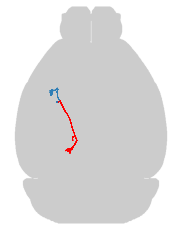

In [12]:
ctx_regions = [nmt.bs.id_to_name(i) for i in nmt.bs.get_all_child_id('CTX')]

def get_cortical(cur_swc):
    # Filtering of swc nodes
    # 1. by type
    cur_swc = cur_swc[cur_swc.type==2]   
    int_swc = cur_swc.copy()
    # 2. by whether cortical
    int_swc[['x', 'y', 'z']] = (cur_swc[['x', 'y', 'z']] / space).astype(int)
    cur_swc = cur_swc[cortex_layer_array[int_swc.x, int_swc.y, int_swc.z]>0]
    return cur_swc

def get_noncortical(cur_swc):
    # Filtering of swc nodes
    # 1. by type
    cur_swc = cur_swc[cur_swc.type==2]   
    int_swc = cur_swc.copy()
    # 2. by whether cortical
    int_swc[['x', 'y', 'z']] = (cur_swc[['x', 'y', 'z']] / space).astype(int)
    cur_swc = cur_swc[cortex_layer_array[int_swc.x, int_swc.y, int_swc.z]==0]
    return cur_swc

def get_x_slice(cur_swc):
    '''
    calculate center of cluster
    '''
    cur_swc = cur_swc[cur_swc['type']>0].copy()
    return cur_swc['x'].mean()

def assign_x_slice(cur_swc, x_list, x_thickness):
    x_list = sorted(x_list)
    df = cur_swc.copy()
    df = df[['x', 'y', 'z']] # Keep axon only
    if len(df)==0:
        return 0
    bins = [int((i-x_thickness/2)) for i in x_list+[x_list[-1]+x_thickness/2]]
    density = np.histogram(df.x, bins)[0]
    return x_list[np.argmax(density)]

def assign_y_slice(cur_swc, y_list=None, y_thickness=None):
    if y_list is None:
        y_thickness = nmt.annotation.space['y']
        y_list = np.arange(nmt.annotation.size['y'])*y_thickness
        y_list = list(y_list)
    y_list = sorted(y_list)
    df = cur_swc.copy()
    df = df[['x', 'y', 'z']] # Keep axon only
    if len(df)==0:
        return 0
    bins = [int((i-y_thickness/2)) for i in y_list+[y_list[-1]+y_thickness/2]]
    density = np.histogram(df.y, bins)[0]
    return y_list[np.argmax(density)]

def assign_z_slice(cur_swc, z_list=None, z_thickness=None):
    if z_list is None:
        z_thickness = nmt.annotation.space['z']
        z_list = np.arange(nmt.annotation.size['z'])*z_thickness
        z_list = list(z_list)
    z_list = sorted(z_list)
    df = cur_swc.copy()
    df = df[['x', 'y', 'z']] # Keep axon only
    if len(df)==0:
        return 0
    bins = [int((i-z_thickness/2)) for i in z_list+[z_list[-1]+z_thickness/2]]
    density = np.histogram(df.z, bins)[0]
    return z_list[np.argmax(density)]

def get_cluster_center(df):
    tp = df.copy()[['z', 'y']]
    distance = metrics.euclidean_distances(tp)
    cid = np.argmin(np.mean(distance, axis=1))
    return [np.int(tp['z'].iloc[cid]), 
            np.int(tp['y'].iloc[cid])]

orb_list = pd.Series(['ORBl', 'ORBm', 'ORBvl', 'ORB'])
def plot_axon_in_cortex(cur_neuron_name, cur_x_slice=None, cur_y_slice=None, cur_z_slice=None, view=None,
                        plot_thickness=400, ax=None, y_shift=0, linewidth=0.5,
#                         noncortical=False, 
                        region_thres=5000,
                        cregions=None
                       ):
    cur_swc = ns.neurons[cur_neuron_name].swc.copy()
    cur_swc['y'] = cur_swc['y']+y_shift
#     if noncortical:
#         cur_swc = get_noncortical(cur_swc)
#     else:
#         cur_swc = get_cortical(cur_swc)
    if len(cur_swc)==0:
        if ax is not None:
            ax.axis('off')
        return None
    # Get target regions
    if cregions is None:
        cregions = get_region_list(cur_neuron_name, threshold=region_thres)
#     print(cregions)
#     '''
#     In this script, neurons are projecting only to the ipsilateral side.
#     If axons are registered mainly to to contralateral side, then flip the neuron
#     '''
#     res1, res2 = get_hemi(cur_neuron_name, noncortical)
#     if np.sum(res1).iloc[0]<np.sum(res2).iloc[0]:
#         cur_swc['z'] = nmt.annotation.micron_size['z'] - cur_swc['z']
        
    # If projecting to ORB, use horizontal view  
    if view is None:
        if orb_list.isin(cregions).any():
            view = 'Horizontal'
            if cur_y_slice is None:
                cur_y_slice = assign_y_slice(cur_swc, None, None)  
        else:
            view = 'Coronal'
            if cur_x_slice is None:
                cur_x_slice = assign_x_slice(cur_swc, x_list_valid, plot_thickness)
    else:
        if ((view == 'Horizontal') & (cur_y_slice is None)):
            cur_y_slice = assign_y_slice(cur_swc, None, None)
        elif ((view == 'Coronal') & (cur_x_slice is None)):
            cur_x_slice = assign_x_slice(cur_swc, None, None)   
        elif ((view == 'Sagittal') & (cur_z_slice is None)):
            cur_z_slice = assign_z_slice(cur_swc, None, None)   
        

    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(2,2))
    
    # Show CCF background
    if view == 'Coronal':
#         slc = ccf_img[int(cur_x_slice/space),:,:midline]
        slc = (np.max(nmt.annotation.array, axis=0) > 0)
    elif view == 'Horizontal':
#         slc = ccf_img[:,int(cur_y_slice/space),:midline]
        slc = (np.max(nmt.annotation.array, axis=1) > 0)
    elif view == 'Sagittal':
#         slc = ccf_img[:,:,int(cur_z_slice/space)]
        slc = (np.max(nmt.annotation.array, axis=2) > 0)
        slc = np.swapaxes(slc, 0,1)

    sub_slc2 = slc
    sub_slc2 = exposure.rescale_intensity(sub_slc2, in_range=(0,255), out_range=(0,255))
    sub_alpha2 = exposure.rescale_intensity(sub_slc2, in_range=(0,155), out_range=(255,0))
    ax.imshow(sub_slc2, cmap='Greys', aspect='auto', alpha=0.2)
#     ax.imshow(sub_slc2, cmap='Greys', aspect='auto', alpha=sub_alpha2)
    
    # Plot swc
    csg = my_swc_to_edges(cur_swc, cregions, space)
    tp = highlight_region(csg, cregions, view=view, ax=ax, linewidth=linewidth, legend=False)    

#     #Axes settings
#     center = get_cluster_center(cur_swc[['x', 'y', 'z']] / space)    
#     ax.set_xlim(min(center[0]+50, nmt.annotation.size['z']), 
#                 max(center[0]-50, 0))
#     ax.set_ylim(min(center[1]+50, nmt.annotation.size['y']), 
#                 max(center[1]-50, 0))    
#     ax.set_title('_'.join(cur_neuron_name.split('_')[:2]))
    ax.axis('off')

    return tp

# SWC plotting function

def node_to_region(df, annotation=nmt.annotation):
    df_int = df[['x', 'y', 'z']].copy()
    df_int['x'] = df_int['x']/annotation.space['x']
    df_int['y'] = df_int['y']/annotation.space['y']
    df_int['z'] = df_int['z']/annotation.space['z']
    df_int = df_int.round(0).astype(int)
    res = pd.DataFrame({'region_id':0}, index=df_int.index)
    # For regions in the CCF space:
    idx = df_int[((df_int.x >= 0) & (df_int.x < annotation.size['x']) &
                  (df_int.y >= 0) & (df_int.y < annotation.size['y']) &
                  (df_int.z >= 0) & (df_int.z < annotation.size['z']))].index.tolist()
    res.loc[idx, 'region_id'] = annotation.array[df_int.loc[idx, 'x'],
                                                 df_int.loc[idx, 'y'],
                                                 df_int.loc[idx, 'z'],
                                                ]
    # Selected regions
    res['region_id'] = res['region_id'].map(nmt.bs.dict_to_selected)
    res['region_id'].fillna(0, inplace=True)
#     idx = res[res['region_id'].isin(list(nmt.bs.dict_to_selected.keys()))].index
#     res.loc[idx, 'region_id'] = res.loc[idx, 'region_id'].map(nmt.bs.dict_to_selected)
#     res.loc[~res['region_id'].index.isin(idx), 'region_id'] = 0
    return res

def my_swc_to_edges(swc, region_list, space):
    '''
    '''
    # 1. Get all edges
    all_nodes = swc.index.tolist()
    children = swc.index[swc.parent.isin(all_nodes)].tolist()
    N = len(children)
    parents = swc.loc[children, "parent"].tolist()
    cuts = [None] * N

    # 2. Create a dataframe with all edges
    # each edge is represented as 3 consecutive rows: [child, parent, empty]
    res = pd.DataFrame(columns=['x', 'y', 'z', 'type'],
                       index=range(N * 3)
                       )
    children_id = np.arange(N) * 3
    parents_id = np.arange(N) * 3 + 1
    cuts_id = np.arange(N) * 3 + 2

    # 2.1. Location columns
    for cur_col in ['x', 'y', 'z']:
        res.loc[children_id, cur_col] = swc.loc[children, cur_col].tolist()
        res.loc[parents_id, cur_col] = swc.loc[parents, cur_col].tolist()
    res.loc[cuts_id, ['x', 'y', 'z']] = None

    # 2.2 Type column
    region_id_list = [nmt.bs.name_to_id(i) for i in region_list]
    region_dict = {}
    for i,cr in enumerate(region_id_list):
        for cr_sub in nmt.bs.get_all_child_id(cr):
            region_dict[cr_sub] = i+1
    
    region = node_to_region(swc.loc[children])
    region['type'] = region['region_id'].map(region_dict)
    region['type'].fillna(0, inplace=True)
    
    res.loc[children_id, 'type'] = region.loc[children, 'type'].tolist()
    res.loc[parents_id, 'type'] = region.loc[children, 'type'].tolist()  # Use child type to represent a segment
    res.loc[cuts_id, 'type'] = region.loc[children, 'type'].tolist()
    # Output
    res[['x', 'y', 'z']] = res[['x', 'y', 'z']] / space
    Xe = res.x.tolist()
    Ye = res.y.tolist()
    Ze = res.z.tolist()
    Te = res.type.tolist()

    return [Xe, Ye, Ze, Te]

def get_hemi(cname, noncortical=True):
    res = ns.features['projection_features'].raw_data.loc[[cname]].copy().transpose()
    # combine hemisphere
    org_id = res.index.tolist()
    std_id = [i.replace('ipsi_', '').replace('contra_', '') for i in org_id]
    id_dict = dict(zip(org_id, std_id))
    std_id = list(set(std_id))
    id1 = [i for i in org_id if i.startswith('ipsi_')]
    id2 = [i for i in org_id if i.startswith('contra_')]
    res1 = res.loc[id1].copy().rename(index=id_dict).loc[std_id]
    res2 = res.loc[id2].copy().rename(index=id_dict).loc[std_id]
    if not noncortical:
        res1 = res1[res1.index.isin(ctx_regions)]
        res2 = res2[res2.index.isin(ctx_regions)]
    return res1, res2


def get_region_list(cname, threshold=5000, noncortical=True):
    res = ns.features['projection_features'].raw_data.loc[[cname]].copy().transpose()
    # combine hemisphere
#     org_id = res.index.tolist()
#     std_id = [i.replace('ipsi_', '').replace('contra_', '') for i in org_id]
#     id_dict = dict(zip(org_id, std_id))
#     std_id = list(set(std_id))
#     id1 = [i for i in org_id if i.startswith('ipsi_')]
#     id2 = [i for i in org_id if i.startswith('contra_')]
#     res1 = res.loc[id1].copy().rename(index=id_dict).loc[std_id]
#     res2 = res.loc[id2].copy().rename(index=id_dict).loc[std_id]
    res1, res2 = get_hemi(cname, noncortical)
    res = res1 + res2
    res = res.sort_values(by=[cname], ascending=False)
    res = res[res[cname]>=threshold].index.tolist()
    
    if not noncortical:
        res = [i for i in res if i in ctx_regions]
    return res
    
def highlight_region(csg, region_list,
                     view="Horizontal", 
                     linewidth = 1,
                     alpha=0.9, 
                     ax=None,
#                      color_list=sns.palettes.color_palette('tab20')[2:],
                     color_list=sns.palettes.color_palette('tab10'),
                     legend=True,
                     legend_all=False
                     ):

    if ax is None:
        fig, ax = plt.figure(1,1, figsize=(4,4))

    #  Plot swc
#     color_list = sns.palettes.color_palette('tab20')[2:]
    
    # Plot swc
    [Xe, Ye, Ze, Te] = csg
    tp = pd.DataFrame(columns=['heng', 'zong', 'Te'])
    if view.lower() == "coronal":
        tp = pd.DataFrame({'heng': Ze, 'zong': Ye, 'Te': Te})
    if view.lower() == "horizontal":
        tp = pd.DataFrame({'heng': Ze, 'zong': Xe, 'Te': Te})
    if view.lower() == "sagittal":
        tp = pd.DataFrame({'heng': Xe, 'zong': Ye, 'Te': Te})
#         ax.invert_yaxis()
    
    ax.plot(tp.heng[tp.Te == 0], tp.zong[tp.Te == 0], c='r', linewidth=linewidth, alpha=1)
    txt_x = np.dot(np.array([-0.05, 1.05]), np.array(ax.get_xlim()))
    txt_y = np.dot(np.array([0.01, 0.99]), np.array(ax.get_ylim()))
    txt_w = (ax.get_ylim()[1] - ax.get_ylim()[0]) / 10
    for j in range(len(region_list)):
        if legend:
            if (((tp.Te == (j+1)).sum()>10) | (legend_all)):
                ax.text(txt_x, txt_y, region_list[j], 
                        fontdict={'ha':'left', 'va':'top', 'fontsize':16}, 
                        color=color_list[(j%9)])
                txt_y = txt_y - txt_w
        ax.plot(tp.heng[tp.Te == (j+1)], 
                tp.zong[tp.Te == (j+1)], 
                c=color_list[(j%9)],
                linewidth=linewidth, 
                alpha=alpha)

    return tp

plot_thickness = ss.x_thickness
region_thres = 100
cregions = ['CP']

fig, ax = plt.subplots(1,1, figsize=(3,4))
tp = plot_axon_in_cortex('17302_00031', region_thres=region_thres, 
                         cregions=cregions, view='Horizontal', ax=ax)

## Metadata

In [13]:
metadata = pd.read_excel('../Data/Hongkui/metadata_IT_hz2_px.xlsx', index_col=[0], sheet_name=1)
# metadata.loc[((metadata.Region.isin(['MOs', 'MOp'])) & (metadata.Layer=='4')), 'Layer'] = '5'
metadata['Region'] = [i.split('-')[0] for i in metadata['Region'].tolist()]
metadata['Layer'] = metadata['Corrected Layer']
metadata.head()

,Registration_Region,Region,Suggested_region,Layer,CreLine,Brain,Yun_celltype,Long_projection,Corrected Layer,HZ comments,HZ comments v2
17300_3426_x20339_y44872,SSs,SSs,SSs,5,Plxnd1,17300,CTX_IT,NaN,5,NaN,Fig 5
17300_3514_x19676_y45282,SSs,SSs,SSs,5,Plxnd1,17300,CTX_IT,NaN,5,NaN,Fig 5
17543_2434_x11441_y5587,SSp-m,SSp,SSp,5,Tlx3,17543,CTX_IT,NaN,5,NaN,Do not use
17543_3705_x9619_y20864,SSp-m,SSs,SSp,5,Tlx3,17543,CTX_IT,NaN,5,NaN,Do not use
17543_3308_x10077_y3766,SSs,SSp,SSs,5,Tlx3,17543,CTX_IT,NaN,5,NaN,Do not use


In [71]:
rlist = ['MOs-L2/3', 'MOp-L2/3', 'MO-L4', 'MO-L5', 'SSp-L2/3', 'SSp-L4', 'SSp-L5', 'SSs-L2/3', 'SSs-L4', 'SSs-L5']
retype_dict = {'MOp;L2/3':'MOp-L2/3',
 'MOp;L4':'MO-L4',
 'MOp;L5':'MO-L5',
 'MOs;L2/3':'MOs-L2/3',
 'MOs;L4':'MO-L4',
 'MOs;L5':'MO-L5',
 'SSp;L2/3':'SSp-L2/3',
 'SSp;L4':'SSp-L4',
 'SSp;L5':'SSp-L5',
 'SSs;L2/3':'SSs-L2/3',
 'SSs;L4':'SSs-L4',
 'SSs;L5':'SSs-L5'}
rlist_raw = list(retype_dict.keys())

df = metadata.copy()

ns_metadata = ns.metadata.copy()
df['Region'] = ns_metadata.loc[df.index, 'Manually_corrected_soma_region'].tolist()
df.loc[df['Region'].str.startswith('SSp'), 'Region'] = 'SSp'
df['Layer'] = ns_metadata.loc[df.index, 'Cortical_layer'].tolist()
df['Corrected Layer'] = ns_metadata.loc[df.index, 'Cortical_layer'].tolist()

df['CellType_full']=[';'.join([df.loc[i, 'Region'], 
                               'L'+str(df.loc[i, 'Layer'])
                              ]) for i in df.index.tolist()]
df = df[df['CellType_full'].isin(rlist_raw)]
df['CellType_full'] = df['CellType_full'].map(retype_dict)
df.CellType_full.value_counts().sort_index()

cell_list = df.index.tolist()

In [38]:
[arbor_dict] = pickle.load(open('./local_arbors_L2-5_IT_v2.pickle', 'rb'))
arbor_list = list(arbor_dict.keys())

In [215]:
[arbor_dict_shift] = pickle.load(open('./local_arbors_L2-5_IT_v2.pickle', 'rb'))


In [218]:
# Adjust vertical locations for some cells
t1 = [i for i in ns.names]
t2 = ['_'.join(i.split('_')[:2]) for i in t1]
tp_dict = dict(zip(t2, t1))

shift_df = pd.read_excel('../Data/Hongkui/Apical_dend_checking_v2.xlsx', 
                        dtype={'Brain':str,
                               'ID':str,
                               'Reach L1':str,
                               'Shift':np.float32})
shift_df['cell_id'] = ['_'.join(shift_df.loc[i, ['Brain', 'ID']].astype(str).tolist()) for i in shift_df.index.tolist()]
shift_df.index = [tp_dict[i] for i in shift_df.cell_id.tolist()]

shift_dict = shift_df.dropna()
shift_dict = dict(zip(shift_dict.index.tolist(), shift_dict.Shift.tolist()))

for i in arbor_list:
    if i in shift_dict.keys():
        arbor_dict_shift[i].depth.depth = arbor_dict_shift[i].depth.depth + shift_dict[i]

In [222]:
arbor_dict_shift[i].depth.depth

84      805.128280
85      807.345949
86      809.622696
87      811.950602
88      814.294313
           ...    
8852    619.731153
8853    620.267193
8854    620.950119
8855    621.796567
8856    622.793961
Name: depth, Length: 14990, dtype: float64

In [226]:
def get_depth_profile(cname_list, arbor_dict=arbor_dict_shift, max_d=2000, nbins=100, ntype=[2,3,4]):
    bins = np.linspace(0, max_d, nbins+1, dtype=int)
    df_dp = pd.DataFrame(index=cname_list, columns=bins[:nbins])

    for cname in cname_list:
        ca = arbor_dict[cname]
        cd = ca.depth.copy()
        cd = pd.concat([cd, ca.seg.loc[cd.index, ['type']]], axis=1)        
        cd = cd[cd.type.isin(ntype)].copy()
        ct = pd.cut(cd.depth, bins, labels=bins[:nbins])
        cd['bin'] = ct[cd.index]
        df_dp.loc[cname] = cd.groupby('bin')['rho'].sum().tolist()/cd['rho'].sum()
    return df_dp

df_dp = get_depth_profile(cell_list[:], ntype=[2])

In [227]:
df_dp

,0,20,40,60,80,100,120,140,160,180,...,1800,1820,1840,1860,1880,1900,1920,1940,1960,1980
17300_3426_x20339_y44872,0.0126972,0.0372682,0.0447827,0.0775189,0.0657261,0.0598817,0.0468559,0.0314197,0.0195097,0.0165169,...,0,0,0,0,0,0,0,0,0,0
17300_3514_x19676_y45282,0.00303845,0.013809,0.0229247,0.0245548,0.0150363,0.0197347,0.0177291,0.00611473,0.00593047,0.00869851,...,0,0,0,0,0,0,0,0,0,0
17543_2434_x11441_y5587,0.0149034,0.0200116,0.0207515,0.0302958,0.0284532,0.0299912,0.0305057,0.0310073,0.0325738,0.0427925,...,0,0,0,0,0,0,0,0,0,0
17543_3705_x9619_y20864,0.00881507,0.0239617,0.0382492,0.0361973,0.0378174,0.0478348,0.0501887,0.0556121,0.0501027,0.0496446,...,0,0,0,0,0,0,0,0,0,0
17543_3308_x10077_y3766,0.0383765,0.0462967,0.0421299,0.0405428,0.0413091,0.0382997,0.0532734,0.032878,0.028169,0.0422869,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191812_4446_x6677_y24393,6.42965e-05,0.00675896,0.0177942,0.0242164,0.0218435,0.0129547,0.00828173,0.00895135,0.00571792,0.00326685,...,0,0,0,0,0,0,0,0,0,0
191812_5922_x4572_y8645,0.0603933,0.129445,0.113976,0.0577021,0.0331757,0.0222491,0.0187305,0.011684,0.0102884,0.0114419,...,0,0,0,0,0,0,0,0,0,0
191812_5219_x4127_y21100,0.0062481,0.0247441,0.0336491,0.0492571,0.0503429,0.0408817,0.0392021,0.0443749,0.0206104,0.0235796,...,0,0,0,0,0,0,0,0,0,0
191812_5676_x8072_y26215,0,0,0.00303405,0.0344323,0.0418478,0.0579709,0.035287,0.0234158,0.0260472,0.0234572,...,0,0,0,0,0,0,0,0,0,0


In [104]:
hue_dict = {'SSp-L2/3':'C0', 
            'SSp-L4':'C3',
            'SSp-L5':'C1', 
            'SSs-L2/3':'C0', 
            'SSs-L4':'C3',
            'SSs-L5':'C1', 
            'MOp-L2/3':'C0', 
            'MOs-L2/3':'C2', 
            'MO-L4':'C3',
            'MO-L5':'C1'}


In [105]:
def layer_shade(region, ax, fontsize=16, only_L1=True, show_ticks=True):
    assert region in layer_thickness_dict.keys(), 'Invalid region name provided'
    layer_thickness = layer_thickness_dict[region]
    ct = 0
    cymin = 0
#     xmin = ax.get_xlim()[0]
    tx = ax.get_xlim()[0]*1.04 + ax.get_xlim()[1]*(-0.04)

    for i in layer_list:
        if not i in layer_thickness.index.tolist():
            continue
        cymax = cymin + layer_thickness[i]
        cymean = (cymin + cymax) / 2
        if (not only_L1) | (i=='L1'):
            if (ct % 2) == 0:
                ax.axhspan(cymin, cymax, color='grey', alpha=0.4, linewidth=0)
            else:
                ax.axhspan(cymin, cymax, color='grey', alpha=0.1, linewidth=0)
        if fontsize>0:
            ax.text(tx, cymean, i, fontdict={'va':'center', 'ha':'right', 'fontsize':fontsize})
        ct += 1
        cymin = cymax
    if show_ticks:
        yticks = [0]
        sum_thickness = 0
        for i in layer_list:
            if not i in layer_thickness.index.tolist():
                continue
            sum_thickness = sum_thickness + layer_thickness[i]
            yticks.append(sum_thickness)
        ax.set_yticks(yticks)
        ax.set_yticklabels([])
        ax.tick_params('both', length=5, width=1, which='major')
    return 1

In [106]:
df.loc[df_dp.index,'CellType_full'].value_counts()

SSp-L4      28
MOp-L2/3    19
SSp-L2/3    18
MOs-L2/3    17
SSp-L5      15
SSs-L2/3    11
SSs-L5      10
MO-L5        8
SSs-L4       4
MO-L4        4
Name: CellType_full, dtype: int64

In [107]:
rlist

['MOs-L2/3',
 'MOp-L2/3',
 'MO-L4',
 'MO-L5',
 'SSp-L2/3',
 'SSp-L4',
 'SSp-L5',
 'SSs-L2/3',
 'SSs-L4',
 'SSs-L5']

In [231]:
sdf = ns.features['soma_features'].raw_data.copy().loc[cell_list]
sdf['depth'] = 0
for i in sdf.index.tolist():
    sdf.loc[i, 'depth'] = arbor_dict_shift[i].depth.loc[0, 'depth']

# MOs-L2/3 cells:	17
# MOp-L2/3 cells:	19
# MO-L4 cells:	4
# MO-L5 cells:	8
# SSp-L2/3 cells:	18
# SSp-L4 cells:	28
# SSp-L5 cells:	15
# SSs-L2/3 cells:	11
# SSs-L4 cells:	4
# SSs-L5 cells:	10


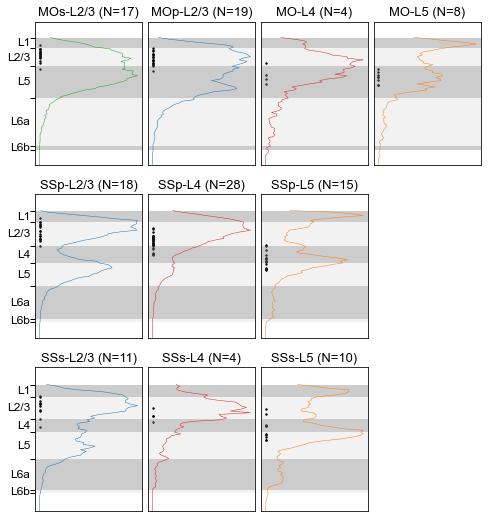

In [235]:
nrow = 3
ncol = 4
fig,ax = plt.subplots(nrow, ncol, figsize=(2*ncol, 3*nrow), gridspec_kw={'wspace':0.05})
rlist_group = [['MOs-L2/3','MOp-L2/3','MO-L4','MO-L5'],
               ['SSp-L2/3','SSp-L4','SSp-L5'],
               ['SSs-L2/3','SSs-L4','SSs-L5']]
group_region = ['MOs', 'SSp', 'SSs']

for i,cgroup in enumerate(rlist_group):
    cregion = group_region[i]
    layer_thickness_dict[cregion].sum() + 200
    max_depth = layer_thickness_dict[cregion].sum() + 200
    for j,ctype in enumerate(cgroup):
        cax = ax[i,j]
        nlist = df[df['CellType_full']==ctype].index.tolist()
        nlist = [k for k in nlist if k in df_dp.index.tolist()]
        print('# %s cells:\t%d' % (ctype, len(nlist)))

        # Profile        
        cdp = df_dp.loc[nlist]
        cdp = pd.DataFrame(cdp.mean(axis=0), columns=['density'])
        cax.plot(cdp.density, cdp.index, lw=0.5, color=hue_dict[ctype])

        if j==0:
            layer_shade(cregion, cax, fontsize=12, only_L1=False, show_ticks=True)
        else:
            layer_shade(cregion, cax, fontsize=0, only_L1=False, show_ticks=False)
            cax.set_yticks([])
        cax.invert_yaxis()
        cax.set_ylim(max_depth, -200)
        cax.set_xticks([])
    #     cax.set_yticks([])
    #     cax.set_title(cgroup, fontdict={'fontsize':14})
        cax.text(np.mean(cax.get_xlim()), 
                 cax.get_ylim()[0]*(-0.06) + cax.get_ylim()[1]*1.06, 
                 ('%s (N=%d)' % (ctype, len(nlist))),
                 fontdict={'ha':'center', 
                           'va':'center', 
                           'rotation':0,
                           'fontsize':13
                          }
                )
        xs = [0]*len(nlist)
        ys = sdf.loc[nlist, 'depth']
        cax.scatter(xs, ys, c='k', s=2)
    for k in range(j+1, ncol):
        cax = ax[i,k]
        cax.axis('off')
fig.savefig('../Figure/L2-5_IT_local_arbor_distribution_shift.pdf', bbox_inches='tight')

In [212]:
ctype = 'SSp-L4'
nlist = df[df['CellType_full']==ctype].index.tolist()
nlist = [k for k in nlist if k in df_dp.index.tolist()]
sdf.loc[nlist].sort_values('depth')

,layer,region,x,y,z,depth
18453_5535_x29214_y5045,2/3,VISrl,7285.350,924.425,2902.450,223.570118
18453_4403_x30609_y7732,2/3,SSp-bfd,6056.700,1979.150,1886.300,276.927272
18453_4231_x30739_y8470,2/3,SSp-n,5828.950,2170.775,1854.650,331.584788
18453_3579_x30397_y10103,2/3,SSp-m,4930.975,2595.925,1951.400,352.252384
18453_4386_x31552_y9254,2/3,SSp-n,6018.175,2397.325,1639.350,357.390679
18453_4496_x31014_y8304,4,SSp-bfd,6163.200,2158.675,1812.575,367.083231
18453_3492_x29357_y9198,2/3,SSp-m,4850.525,2235.475,2385.325,402.207651
18453_4749_x31789_y8895,4,SSp-bfd,6477.550,2374.350,1635.500,417.710304
18453_3471_x28224_y8289,2/3,SSp-ul,4836.700,1905.975,2862.075,422.780094
18453_3704_x10450_y7387,2/3,SSp-ul,4660.700,1984.450,2909.500,433.002862


In [214]:
ns.metadata.loc['17543_2434_x11441_y5587']

formatted name                                  17543_2434_x11441_y5587
Soma_x                                                          5027.07
Soma_y                                                          3176.28
Soma_z                                                          2293.38
Registered_soma_region                                            SSp-m
Manually_corrected_soma_region                                    SSp-m
Cortical_layer                                                        4
Transgenic_line                   Tlx3-Cre_PL56;Ai82;Ai161_325875-17543
Brain_id                                                          17543
Subclass_or_type                                                 CTX_IT
Notes                                                               NaN
Name: 17543_2434_x11441_y5587, dtype: object